In [1]:
import numpy as np
import pylab as p
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3


from scipy.integrate import solve_ivp
import pysindy as ps

Create a Lorenz System of the form:
\begin{cases}
\dot{x} &= \sigma (y-x)\\
\dot{y} &= (\rho *x) - y - (xz)\\
\dot{z} &= xy-\beta z
\end{cases}

`lorenz_system` takes as inputs $(x_0, y_0, z_0, \sigma, \rho, \beta)$

In [2]:
##############################
# define Lorenz system
##############################
def lorenz_system(t,x0,sigma,rho,beta):
    x = x0[0]
    y = x0[1]
    z = x0[2]
    def x_prime(x,y,z):
        return sigma*(y-x)
    def y_prime(x,y,z):
        return (rho*x)-y-(x*z)
    def z_prime(x,y,z):
        return (x*y)-(beta*z)
    return np.array([x_prime(x,y,z), y_prime(x,y,z), z_prime(x,y,z)])


In [3]:
##############################
# initialize t
##############################
t0 = 0.0 
tf = 900.
stepsize = 0.01
tspan = np.arange(t0, tf + stepsize, stepsize)

##############################
# desired learned values
##############################
sigma = 5.2
rho = 15.0
beta = 1.0

##############################
# generate some training data
##############################
init_value = np.array([10.0,12.0,10.0])

sol = solve_ivp(lorenz_system, [t0, tf], init_value, t_eval=tspan, method='RK45', args=(sigma, rho, beta))

lorenz = np.transpose(sol.y)

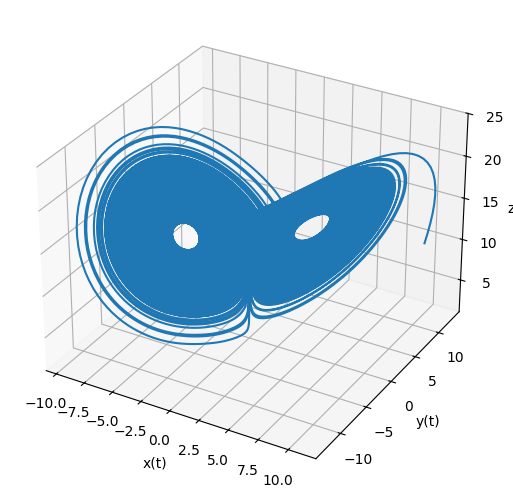

In [4]:
##############################
# Plot training data
##############################
fig=p.figure()
ax = p3.Axes3D(fig)
ax.plot3D(lorenz[:,0],lorenz[:,1],lorenz[:,2])
ax.set_xlabel('x(t)')
ax.set_ylabel('y(t)')
ax.set_zlabel('z(t)')
fig.add_axes(ax)
p.show()

In [94]:
##############################
# Construct SINDy model
##############################

differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.2)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y", "z"],
)

In [95]:
##############################
# Fit SINDy model to lorenz data
##############################

model.fit(lorenz, t=tspan)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3),
      feature_names=['x', 'y', 'z'], optimizer=STLSQ(threshold=0.2))

In [96]:
model.print()

(x)' = -5.200 x + 5.200 y
(y)' = 14.879 x + -0.973 y + -0.993 x z
(z)' = -1.000 z + 0.999 x y


In [126]:
init_value = np.array([10.0,12.0,10.0])
tmp_final_t = 9000

sim = model.simulate(init_value, t=tspan[0:tmp_final_t])

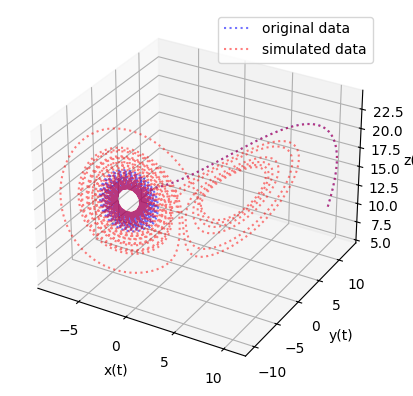

In [134]:
##############################
# Plot training data vs simulated data of learned model
##############################

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(lorenz[0:tmp_final_t,0],lorenz[0:tmp_final_t,1],lorenz[0:tmp_final_t,2], 'b:',
            alpha=0.55, label='original data')
ax.plot3D(sim[0:tmp_final_t,0],sim[0:tmp_final_t,1],sim[0:tmp_final_t,2], 'r:', 
            alpha=0.5, label='simulated data')
ax.set_xlabel('x(t)')
ax.set_ylabel('y(t)')
ax.set_zlabel('z(t)')
ax.legend()
fig.add_axes(ax)
plt.show()